Your challenge in this competition is to forecast microbusiness activity across the United States, as measured by the density of microbusinesses in US counties. Microbusinesses are often too small or too new to show up in traditional economic data sources, but microbusiness activity may be correlated with other economic indicators of general interest.

As historic economic data are widely available, this is a forecasting competition. The forecasting phase public leaderboard and final private leaderboard will be determined using data gathered after the submission period closes. You will make static forecasts that can only incorporate information available before the end of the submission period. This means that while we will rescore submissions during the forecasting period we will not rerun any notebooks.

**train.csv**

<b>row_id</b> - An ID code for the row.<br>
**cfips** - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.<br>
**county_name** - The written name of the county.<br>
**state_name** - The name of the state.<br>
**first_day_of_month** - The date of the first day of the month.<br>
**microbusiness_density** - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.<br>
**active** - The raw count of microbusinesses in the county. Not provided for the test set.<br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
sns.set()
import missingno as msno

In [ ]:
df_train=pd.read_csv("train.csv")

In [23]:
df_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [24]:
df_test=pd.read_csv("Documents/FAU_Courses/FirstSemester/Machine Learning For Time Series/godaddy-microbusiness-density-forecasting/test.csv")

In [25]:
df_test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


## Dealing with time

Before moving into exploratory data analysis, let's make sure that our time variable is converted to a timestamp, it will be useful for later.

In [6]:
df_train['datetime'] = pd.to_datetime(df_train['first_day_of_month'])
df_train = df_train.set_index('datetime')
df_train.drop(['first_day_of_month'], axis=1, inplace=True)
df_train.head(10)

,row_id,cfips,county,state,microbusiness_density,active
datetime,,,,,,
2019-08-01,1001_2019-08-01,1001,Autauga County,Alabama,3.007682,1249
2019-09-01,1001_2019-09-01,1001,Autauga County,Alabama,2.884870,1198
2019-10-01,1001_2019-10-01,1001,Autauga County,Alabama,3.055843,1269
2019-11-01,1001_2019-11-01,1001,Autauga County,Alabama,2.993233,1243
2019-12-01,1001_2019-12-01,1001,Autauga County,Alabama,2.993233,1243
2020-01-01,1001_2020-01-01,1001,Autauga County,Alabama,2.969090,1242
2020-02-01,1001_2020-02-01,1001,Autauga County,Alabama,2.909326,1217
2020-03-01,1001_2020-03-01,1001,Autauga County,Alabama,2.933231,1227
2020-04-01,1001_2020-04-01,1001,Autauga County,Alabama,3.000167,1255


There are 6 variables, 122.265 rows and their types are mix of object and int/float. Object types might need to be converted to int variables later.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122265 entries, 2019-08-01 to 2022-10-01
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   microbusiness_density  122265 non-null  float64
 5   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [8]:
type(df_train.index[0])

pandas._libs.tslibs.timestamps.Timestamp

Our time index iss printed as timestamp, so it's done.

## Exploratory Data Analysis

Let's check number of unique observations for each feature, to better understand the figures.

In [9]:
for i in df_train.columns:
    print("unique number of obs for " + str(i) +" is : "+str(len(df_train[i].unique().tolist())))
print("unique number of obs for time variable is : "+str(len(df_train.index.unique().tolist())))

unique number of obs for row_id is : 122265
unique number of obs for cfips is : 3135
unique number of obs for county is : 1871
unique number of obs for state is : 51
unique number of obs for microbusiness_density is : 97122
unique number of obs for active is : 19193
unique number of obs for time variable is : 39


There is 3135 unique county (cfips), while 51 unique state. Dataset is consist of 39 months.

<AxesSubplot:>

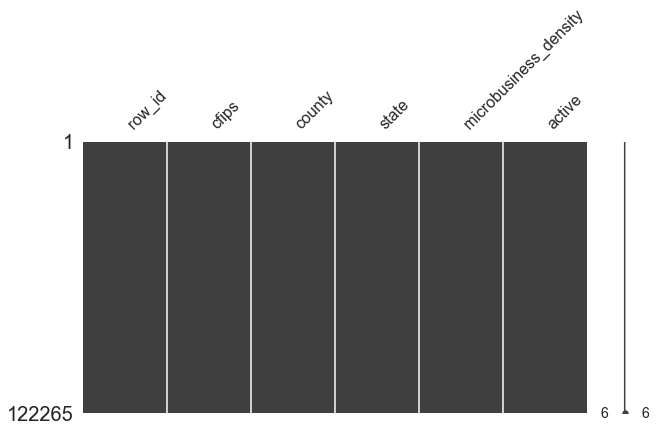

In [10]:
msno.matrix(df_train,figsize=(10,5))

We employed msno from missingno library to check how many number of observations are missing in the dataset. There is no missing observations. It is 100% full!

In [11]:
df_train.groupby(['state']).describe()['microbusiness_density'].sort_values('std')

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
District of Columbia,39.0,13.508989,0.294487,12.787801,13.269190,13.551914,13.697423,14.005946
Rhode Island,195.0,6.985363,1.207692,4.969075,6.032383,7.264053,8.120277,8.660382
West Virginia,2145.0,1.855457,1.241438,0.360211,0.878539,1.453722,2.542662,7.043378
Arkansas,2925.0,1.998925,1.497099,0.247328,0.974982,1.531890,2.445632,16.291933
Kansas,4095.0,2.463091,1.532490,0.562430,1.576070,2.148502,2.800141,14.035515
Mississippi,3198.0,1.696296,1.539697,0.000000,0.863192,1.305429,1.952426,14.852497
Alabama,2613.0,2.223274,1.584220,0.438305,1.202177,1.639288,2.709124,8.573463
Kentucky,4680.0,2.077160,1.731339,0.224027,0.953756,1.593625,2.662017,14.448168
Ohio,3432.0,3.034945,1.765796,0.637639,1.686132,2.482716,3.726996,9.845983


Since we have 3135 unique counties, let's first try to plot mean of microbusiness density across all 3135 counties.

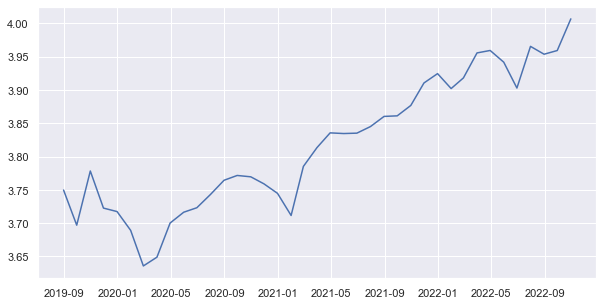

In [12]:
plt.figure(figsize=(10,5))
plt.plot(df_train.microbusiness_density.resample('M').mean())
plt.show()

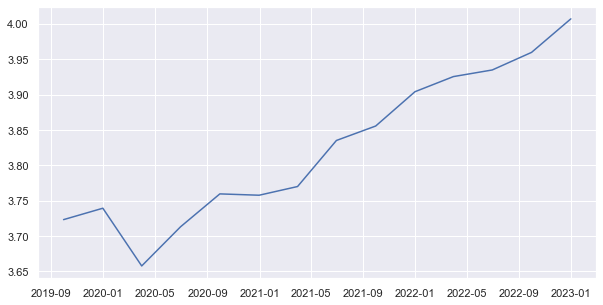

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_train.microbusiness_density.resample('Q').mean())
plt.show()